In [1]:
import torch
from torch import nn
import torchvision
from torch.utils.data import TensorDataset
import numpy as np
from torch.utils.data.dataloader import DataLoader

In [2]:
torch.cuda.is_available()

True

# Patch Embedding

In [3]:
class PatchEmbed(nn.Module):
    """ Split image into patches and convert into embeddings
    
    Parameters
    ____________
    img_size: int
        Size of the image
    patch_size: int
        Size of each patch
    in_channel: int
        number of input chanels
    embedding: int
        the embedding dimension
        
    Attributes
    ____________
    self.n_patches: int
        Number of patches to split the image into
    self.proj: Conv2D()
        Convert image into patches and give their embeddings
        
    """
    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (self.img_size // patch_size)**2
        self.proj = nn.Conv2d(
            in_chans, 
            embed_dim, 
            kernel_size=patch_size, 
            stride=patch_size
        )
    
    def forward(self, x):
        """Run Forward Pass
        
        Parameters
        ______________
        x: torch.Tensor
            Shape (n_samples, in_channel, img_size, img_size)
        
        Returns
        ______________
        torch.Tensor
            Shape (n_samples, n_patches, embedding)
        
        """
        x = self.proj(x) # Shape (no_of_samples, embedding_dim, n_patches ** 1/2, n_patches ** 1/2)
        x = x.flatten(2) # Shape (no_of_samples, embedding_dim, n_patches)
        x = x.transpose(1, 2) # Shape (no_of_samples, n_patches, embedding_dim)
        return x

# Sanity Check

Image of size 128 x 128, and patch size 2 x 2 should yield 4096 patches

In [4]:
inps = np.ones((128, 128, 3))                                      
inps.shape

(128, 128, 3)

In [5]:
transform = torchvision.transforms.ToTensor()
inps = transform(inps).float()

In [6]:
inps.shape

torch.Size([3, 128, 128])

In [7]:
inps = inps.unsqueeze(0)
inps.shape

torch.Size([1, 3, 128, 128])

In [8]:
tgts = np.array([1])
tgts = np.expand_dims(tgts, axis=0)
tgts.shape

(1, 1)

In [9]:
tgts = transform(tgts)
tgts.shape

torch.Size([1, 1, 1])

In [10]:
dataset = TensorDataset(inps, tgts)

In [11]:
dataloader = DataLoader(dataset, batch_size=1) 

In [15]:
dataset_iter = iter(dataloader)

In [16]:
patch_embedding = PatchEmbed(128, 2).cuda()

In [17]:
for inp, gt in dataset_iter:
    inp = inp.cuda()
    print("input shape: ", inp.shape)
    assert patch_embedding(inp).shape[1] == 4096

input shape:  torch.Size([1, 3, 128, 128])


# Attention

In [17]:
module = torch.nn.Dropout(0.50)
print("Training mode: ", module.training)
x = np.ones((2, 2))
convert_to_tensor = torchvision.transforms.ToTensor()
x = convert_to_tensor(x)
print(module(x))

module.eval()
print("Training mode: ", module.training)
print(module(x))

Training mode:  True
tensor([[[2., 2.],
         [2., 2.]]], dtype=torch.float64)
Training mode:  False
tensor([[[1., 1.],
         [1., 1.]]], dtype=torch.float64)


In [18]:
class Attention(nn.Module):
    """ Split image into patches and convert into embeddings
    
    Parameters
    _____________
    dim: int
        Input dimensions (positional aware embeddings) and output dimensions stay the same
        
    n_heads: int
        Number of self attention modules to distribute the cognitive load
        
    qkv_bias: bool
        Whether to add bias in query, keys and value projections
        
    attn_p: float
        dropout applied to q, k and v
        
    proj_p: float
        dropout applied to output
        
    Attributes
    _____________
    proj: nn.Linear
        input channels = dim, output channels = dim to map concatenated attention heads output to a new space
        
    """
    def __init__(self, dim, n_heads, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = self.dim // n_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim*3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)
        
        
    def forward(self, x):
        """Run Forward Pass
        
        Parameters
        ______________
        x: torch.Tensor
            Shape (n_samples, n_patches + 1, embedding)
        
        Returns
        ______________
        torch.Tensor
            Shape (n_samples, n_patches + 1, embedding)
        
        """
        n_samples, n_tokens, dim = x.shape
        if dim != self.dim:
            raise ValueError
        qkv = self.qkv(x) # (n_samples, n_patches + 1, embedding_dim * 3)
        qkv = qkv.reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim) # (n_samples, n_patches + 1, 3, n_heads, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4) # (3, n_samples, self.n_heads, n_patches + 1, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1) # (n_samples, self.n_heads, head_dim, n_patches + 1)
        
        dp = (q @ k_t) * self.scale # (n_samples, self.n_heads, n_patches + 1, n_patches + 1)
        attn = dp.softmax(dim=-1)
        attn = self.attn_drop(attn)
        weighted_avg = attn @ v # (n_samples, self.n_heads, n_patches + 1, head_dim)
        weighted_avg = weighted_avg.transpose(1, 2) # (n_samples, n_patches + 1, self.n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2) # (n_samples, n_patches + 1, embedding_dim)
        
        x = self.proj(weighted_avg) # (n_samples, n_patches + 1, embedding_dim)
        x = self.proj_drop(x) # (n_samples, n_patches + 1, embedding_dim)
        
        return x

In [19]:
dataset_iter = iter(dataloader)

In [20]:
attn = Attention(768, 12, True, 0, 0) # 12 attention heads, so the dimension of each head is 768/12=64
attn = attn.cuda()
for inp, gt in dataset_iter:
    inp = inp.cuda()
    patch_emb = patch_embedding(inp)
    # Skipping the positonal aware embeddings for now
    print(attn(patch_emb).shape)
    break

torch.Size([1, 4096, 768])


In [21]:
class MLP(nn.Module):
    '''Parameters
    _____________________
    in_features: int
        Number of input features
        
    hidden_features: int
        Number of hidden features
        
    out_features: int
        Number of output features
        
    p: float
        Dropout probability
    
    Attributes
    ______________________
    fc: nn.Linear
        The first linear layer
        
    fc2: nn.Linear
        The second linear layer
        
    act: nn.GELU
        GELU activation function
        
    dropout: nn.Dropout
        Dropout layer'''
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)
    
    def forward(self, x):
        '''
        Parameters
        __________________
        x: torch.Tensor -> (n_samples, n_patches + 1, embedding_dim)
        
        Returns
        __________________
        x: torch.Tensor -> (n_samples, n_patches + 1, embedding_dim)'''
        x = self.fc1(
                x
        ) # (n_samples, n_patches + 1, hidden_features)
        x = self.act(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.fc2(x)  # (n_samples, n_patches + 1, out_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, out_features)

        return x

In [22]:
class Block(nn.Module):
        """Transformer block.
        Parameters
        ----------
        dim : int
            Embeddinig dimension.

        n_heads : int
            Number of attention heads.

        mlp_ratio : float
            Determines the hidden dimension size of the `MLP` module with respect
            to `dim`.

        qkv_bias : bool
            If True then we include bias to the query, key and value projections.

        p, attn_p : float
            Dropout probability.

        Attributes
        ----------
        norm1, norm2 : LayerNorm
            Layer normalization.

        attn : Attention
            Attention module.

        mlp : MLP
            MLP module.
        """
        def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
            super().__init__()
            self.norm1 = nn.LayerNorm(dim, eps=1e-6)
            self.attn = Attention(
                dim, 
                n_heads, 
                qkv_bias=qkv_bias,
                attn_p=attn_p,
                proj_p=p
            )
            self.norm2 = nn.LayerNorm(dim, eps=1e-6)
            self.mlp = MLP(
                dim, 
                int(dim * mlp_ratio), 
                dim
            )
            
        def forward(self, x):
            '''
            Parmeters
            _______________
            x: torch.Tensor -> Shape (no_of_samples, n_patches + 1, embedding_dim)
            
            Returns
            _______________
            x: torch.Tensor -> Shape (no_of_samples, n_patches + 1, embedding_dim)
            '''
            x = x + self.attn(self.norm1(x))
            x = x + self.mlp(self.norm2(x))

            return x

In [23]:
class VisionTransformer(nn.Module):
    """Simplified implementation of the Vision transformer.

    Parameters
    ----------
    img_size : int
        Both height and the width of the image (it is a square).

    patch_size : int
        Both height and the width of the patch (it is a square).

    in_chans : int
        Number of input channels.

    n_classes : int
        Number of classes.

    embed_dim : int
        Dimensionality of the token/patch embeddings.

    depth : int
        Number of blocks.

    n_heads : int
        Number of attention heads.

    mlp_ratio : float
        Determines the hidden dimension of the `MLP` module.

    qkv_bias : bool
        If True then we include bias to the query, key and value projections.

    p, attn_p : float
        Dropout probability.

    Attributes
    ----------
    patch_embed : PatchEmbed
        Instance of `PatchEmbed` layer.

    cls_token : nn.Parameter
        Learnable parameter that will represent the first token in the sequence.
        It has `embed_dim` elements.

    pos_emb : nn.Parameter
        Positional embedding of the cls token + all the patches.
        It has `(n_patches + 1) * embed_dim` elements.

    pos_drop : nn.Dropout
        Dropout layer.

    blocks : nn.ModuleList
        List of `Block` modules.

    norm : nn.LayerNorm
        Layer normalization.
    """
    def __init__(
            self,
            img_size=384,
            patch_size=16,
            in_chans=3,
            n_classes=1000,
            embed_dim=768,
            depth=12,
            n_heads=12,
            mlp_ratio=4.,
            qkv_bias=True,
            p=0.,
            attn_p=0.,
    ):
        super().__init__()

        self.patch_embed = PatchEmbed(
                img_size=img_size,
                patch_size=patch_size,
                in_chans=in_chans,
                embed_dim=embed_dim,
        )
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(
                torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim)
        )
        self.pos_drop = nn.Dropout(p=p)

        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )

        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, n_classes)


    def forward(self, x):
        """Run the forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.

        Returns
        -------
        logits : torch.Tensor
            Logits over all the classes - `(n_samples, n_classes)`.
        """
        n_samples = x.shape[0]
        x = self.patch_embed(x)

        cls_token = self.cls_token.expand(
                n_samples, -1, -1
        )  # (n_samples, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1)  # (n_samples, 1 + n_patches, embed_dim)
        x = x + self.pos_embed  # (n_samples, 1 + n_patches, embed_dim)
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        cls_token_final = x[:, 0]  # just the CLS token
        x = self.head(cls_token_final)

        return x

In [24]:
import timm

# Helpers
def get_n_params(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

def assert_tensors_equal(t1, t2):
    a1, a2 = t1.detach().numpy(), t2.detach().numpy()

    np.testing.assert_allclose(a1, a2)

model_name = "vit_base_patch16_384"
model_official = timm.create_model(model_name, pretrained=True)
model_official.eval()
print(type(model_official))

custom_config = {
        "img_size": 384,
        "in_chans": 3,
        "patch_size": 16,
        "embed_dim": 768,
        "depth": 12,
        "n_heads": 12,
        "qkv_bias": True,
        "mlp_ratio": 4,
}

model_custom = VisionTransformer(**custom_config)
model_custom.eval()


for (n_o, p_o), (n_c, p_c) in zip(
        model_official.named_parameters(), model_custom.named_parameters()
):
    assert p_o.numel() == p_c.numel()
    print(f"{n_o} | {n_c}")

    p_c.data[:] = p_o.data

    assert_tensors_equal(p_c.data, p_o.data)

inp = torch.rand(1, 3, 384, 384)
res_c = model_custom(inp)
res_o = model_official(inp)

# Asserts
assert get_n_params(model_custom) == get_n_params(model_official)
assert_tensors_equal(res_c, res_o)

# Save custom model
torch.save(model_custom, "model.pth")


<class 'timm.models.vision_transformer.VisionTransformer'>
cls_token | cls_token
pos_embed | pos_embed
patch_embed.proj.weight | patch_embed.proj.weight
patch_embed.proj.bias | patch_embed.proj.bias
blocks.0.norm1.weight | blocks.0.norm1.weight
blocks.0.norm1.bias | blocks.0.norm1.bias
blocks.0.attn.qkv.weight | blocks.0.attn.qkv.weight
blocks.0.attn.qkv.bias | blocks.0.attn.qkv.bias
blocks.0.attn.proj.weight | blocks.0.attn.proj.weight
blocks.0.attn.proj.bias | blocks.0.attn.proj.bias
blocks.0.norm2.weight | blocks.0.norm2.weight
blocks.0.norm2.bias | blocks.0.norm2.bias
blocks.0.mlp.fc1.weight | blocks.0.mlp.fc1.weight
blocks.0.mlp.fc1.bias | blocks.0.mlp.fc1.bias
blocks.0.mlp.fc2.weight | blocks.0.mlp.fc2.weight
blocks.0.mlp.fc2.bias | blocks.0.mlp.fc2.bias
blocks.1.norm1.weight | blocks.1.norm1.weight
blocks.1.norm1.bias | blocks.1.norm1.bias
blocks.1.attn.qkv.weight | blocks.1.attn.qkv.weight
blocks.1.attn.qkv.bias | blocks.1.attn.qkv.bias
blocks.1.attn.proj.weight | blocks.1.attn

inp shape:  (183, 275, 3)
inp shape:  (384, 384, 3)
torch.Size([1, 1000])
0: hen                                           --- 0.7596
1: partridge                                     --- 0.1206
2: cock                                          --- 0.0626
3: prairie_chicken, prairie_grouse, prairie_fowl --- 0.0029
4: black_grouse                                  --- 0.0019
5: ruffed_grouse, partridge, Bonasa_umbellus     --- 0.0014
6: croquet_ball                                  --- 0.0005
7: patas, hussar_monkey, Erythrocebus_patas      --- 0.0005
8: ptarmigan                                     --- 0.0005
9: milk_can                                      --- 0.0004


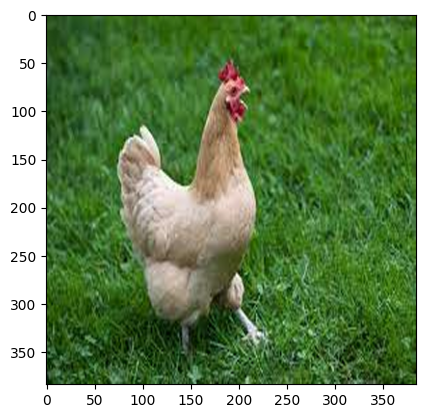

In [28]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2

k = 10

imagenet_labels = dict(enumerate(open("classes.txt")))

model = torch.load("model.pth")
model.eval()

inp = np.array(Image.open("hen.jpg"))
print("inp shape: ", inp.shape)
inp = cv2.resize(inp, dsize=(384, 384), interpolation=cv2.INTER_CUBIC)
print("inp shape: ", inp.shape)
plt.imshow(inp)

img = (inp / 128) - 1  # in the range -1, 1
inp = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).to(torch.float32)
logits = model(inp)
print(logits.shape)
probs = torch.nn.functional.softmax(logits, dim=-1) # convert logits into discrete probabilities

top_probs, top_ixs = probs[0].topk(k) # get top 10 probabilities with output labels

for i, (ix_, prob_) in enumerate(zip(top_ixs, top_probs)):
    ix = ix_.item() # converts tensor into integer
    prob = prob_.item()
    cls = imagenet_labels[ix].strip()
    print(f"{i}: {cls:<45} --- {prob:.4f}")
